    Jacob Knopping
    3/12/2020
    
## Unsupervised Learning Capstone: Breast Cancer Wisconsin Dataset

### Introduction

The dataset used in this capstone project is the Breast Cancer Wisconsin (Diagnostic) dataset from Kaggle (https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). It can also be found in the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). 

There are 32 columns in this dataset, and the column variables were computed using a digitized image of a breast tumor (specifically an image of a fine needle aspirate, or FNA) from . The variables describe the cell nuclei present, by assigning values for the following:

    radius
    texture
    perimeter
    area
    smoothness
    compactness
    concavity
    concave points
    symmetry
    fractal dimension
    
Mean, standard error, and worst were calculated for each of the above variables, resulting in 30 of 32 of the feature columns. "Worst" is really the mean of the three largest values. The final two categories are ID number and the diagnosis (B = benign tumor, M = malignant tumor).

The goal of this unsupervised learning capstone is to answer the following question: can clustering techniques be used to find a distinction between benign and malignant tumors, based on their physial attributes?

### Importing the Data

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import time

# unsupervised learning models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [2]:
#Read csv file into dataframe
df = pd.read_csv('breast-cancer-wisconsin-data.csv')
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)

In [3]:
df.shape

(569, 32)

In [4]:
df.head(4)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

### Data Cleaning (Missing Values and Outliers)

The .describe() method can be used to generate summary statistics for all numeric columns, which will be useful information when evaluating whether or not to account for outliers.

In [6]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [7]:
# Confirm there is no missing data
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

There are no missing values to consider in this dataset. However, the ID column and diagnosis column are not necessary for this unsupervised clustering task.

In [8]:
# drop ID column
df = df.drop('id', axis=1)

# store and then drop ground truth for now
diagnosis = df.diagnosis
df = df.drop('diagnosis', axis =1)

Nexy, Tukey's method for detecting outliers can applied to this dataset to understand the impact of potential outliers on this dataset, and whether or not the potential outliers should be treated as such.

In [9]:
fill_list = list(df.columns)

#Detecting outliers using Tukey's method(IQR range)
for column in fill_list:
    q75, q25 = np.percentile(df[column], [75 ,25])
    iqr = q75 - q25
    #This method considers all values that are outside the threshold of 1.5 times the IQR as outliers
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers in {}: {}".format(
        column, 
        len((np.where((df[column] > max_val) | (df[column] < min_val))[0]))))

Number of outliers in radius_mean: 14
Number of outliers in texture_mean: 7
Number of outliers in perimeter_mean: 13
Number of outliers in area_mean: 25
Number of outliers in smoothness_mean: 6
Number of outliers in compactness_mean: 16
Number of outliers in concavity_mean: 18
Number of outliers in concave points_mean: 10
Number of outliers in symmetry_mean: 15
Number of outliers in fractal_dimension_mean: 15
Number of outliers in radius_se: 38
Number of outliers in texture_se: 20
Number of outliers in perimeter_se: 38
Number of outliers in area_se: 65
Number of outliers in smoothness_se: 30
Number of outliers in compactness_se: 28
Number of outliers in concavity_se: 22
Number of outliers in concave points_se: 19
Number of outliers in symmetry_se: 27
Number of outliers in fractal_dimension_se: 28
Number of outliers in radius_worst: 17
Number of outliers in texture_worst: 5
Number of outliers in perimeter_worst: 15
Number of outliers in area_worst: 35
Number of outliers in smoothness_wo

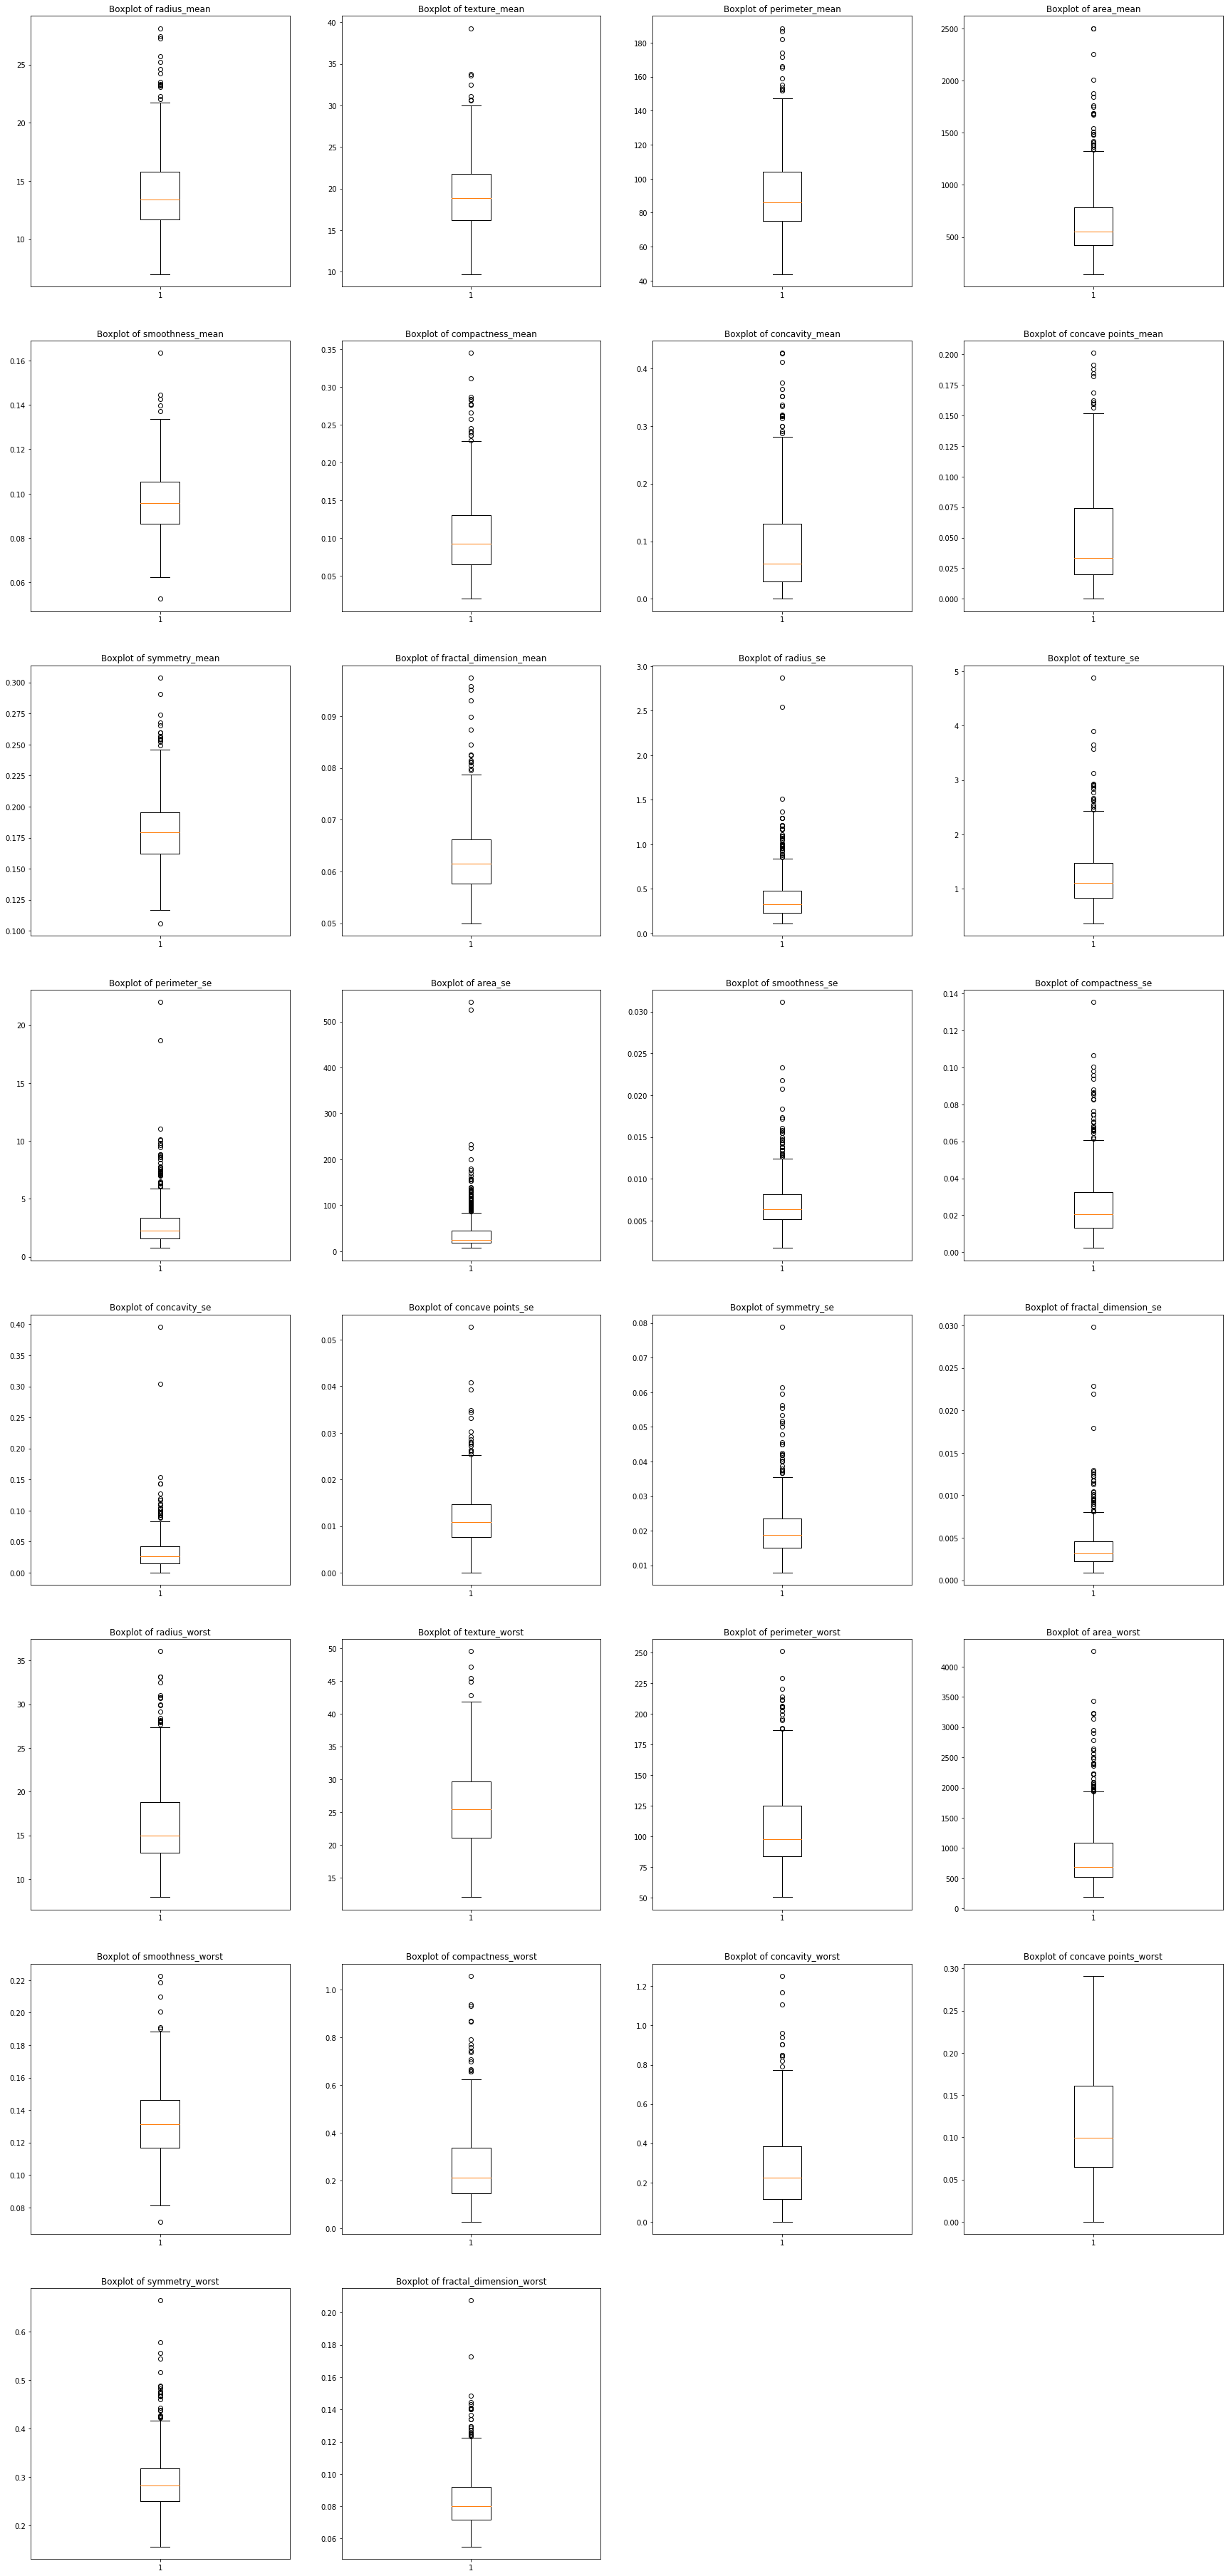

In [10]:
#Visual examination of outliers:
plt.figure(figsize=(30,250))

for i, column in enumerate(fill_list):
    plt.subplot(len(fill_list), 4, i+1)
    plt.boxplot(df[column])
    plt.title("Boxplot of {}".format(column))
    
plt.show()

The proportion of outliers for each variable appears relatively low, and the box plots don't generally appear to be dramatically condensed (which would be indicative of outliers having a large impact). That said, let's apply two-way winsorization to the potenital outliers to get a better sense of their impact.

In [11]:
# Apply two-way winsorization to deal with outliers
from scipy.stats.mstats import winsorize

for column in fill_list:
    df[column] = winsorize(df[column], (.05, .05))

In [12]:
#Detecting outliers using Tukey's method(IQR range)
for column in fill_list:
    q75, q25 = np.percentile(df[column], [75 ,25])
    iqr = q75 - q25
    #This method considers all values that are outside the threshold of 1.5 times the IQR as outliers
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers in {}: {}".format(
        column, 
        len((np.where((df[column] > max_val) | (df[column] < min_val))[0]))))

Number of outliers in radius_mean: 0
Number of outliers in texture_mean: 0
Number of outliers in perimeter_mean: 0
Number of outliers in area_mean: 0
Number of outliers in smoothness_mean: 0
Number of outliers in compactness_mean: 0
Number of outliers in concavity_mean: 0
Number of outliers in concave points_mean: 0
Number of outliers in symmetry_mean: 0
Number of outliers in fractal_dimension_mean: 0
Number of outliers in radius_se: 38
Number of outliers in texture_se: 0
Number of outliers in perimeter_se: 38
Number of outliers in area_se: 65
Number of outliers in smoothness_se: 30
Number of outliers in compactness_se: 0
Number of outliers in concavity_se: 0
Number of outliers in concave points_se: 0
Number of outliers in symmetry_se: 0
Number of outliers in fractal_dimension_se: 0
Number of outliers in radius_worst: 0
Number of outliers in texture_worst: 0
Number of outliers in perimeter_worst: 0
Number of outliers in area_worst: 35
Number of outliers in smoothness_worst: 0
Number of

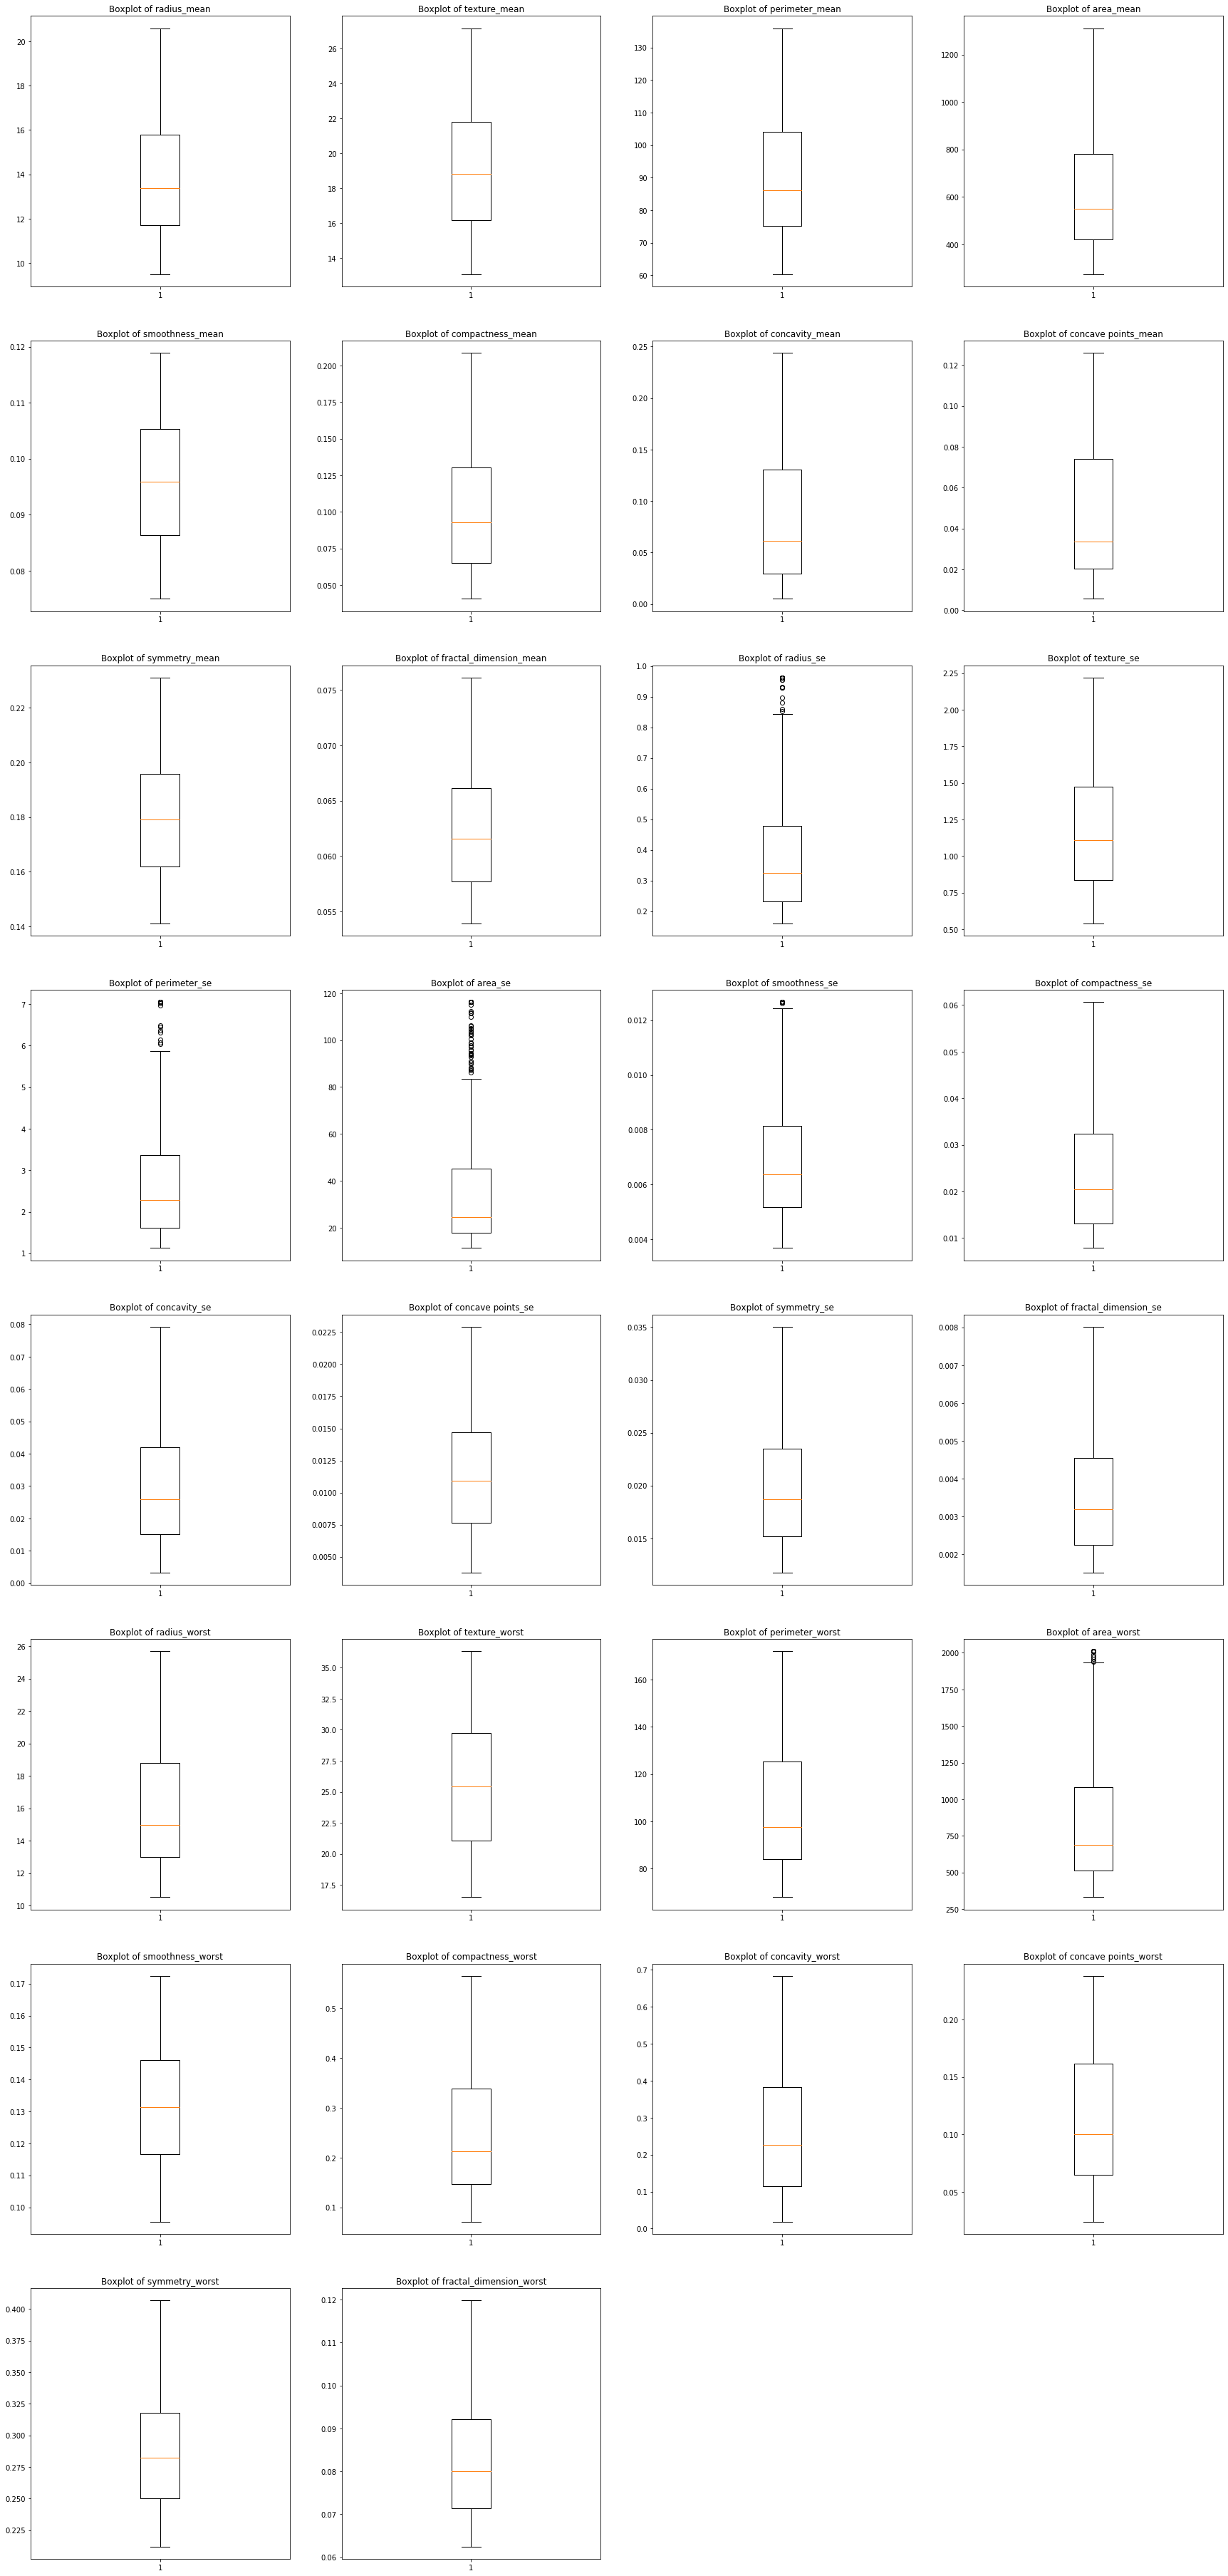

In [13]:
#Visual examination of outliers:
plt.figure(figsize=(30,250))

for i, column in enumerate(fill_list):
    plt.subplot(len(fill_list), 4, i+1)
    plt.boxplot(df[column])
    plt.title("Boxplot of {}".format(column))
    
plt.show()

In [14]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.053968,19.217838,91.354534,641.062039,0.096103,0.102693,0.085655,0.047772,0.180568,0.062580,...,16.161476,25.556626,106.398647,856.309490,0.131953,0.248150,0.266325,0.114306,0.288186,0.083340
std,3.180805,3.898115,21.781108,301.032372,0.012455,0.047084,0.070099,0.035054,0.024027,0.006057,...,4.380800,5.630052,30.189145,482.354358,0.020740,0.135969,0.189235,0.062315,0.050555,0.015442
min,9.504000,13.080000,60.340000,273.900000,0.074970,0.040520,0.004967,0.005592,0.141100,0.053910,...,10.510000,16.510000,67.840000,330.700000,0.095450,0.070940,0.018240,0.023810,0.212100,0.062510
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,20.580000,27.150000,135.900000,1311.000000,0.118900,0.208700,0.243900,0.125900,0.231000,0.076130,...,25.680000,36.320000,172.000000,2010.000000,0.172400,0.564600,0.683300,0.237800,0.406600,0.119800


Upon further consideration, each value in the dataset will be kept. Given that this is medical data, every value is real and has value. Higher values are indicative of real, more serious conditions. Additionally, there are no obvious entry errors or extreme instances affecting the rest of the data, based on the boxplots and .describe() summary statisitcs. In addition, winsorization did not seem to significantly impact summary statistics  (i.e. mean), suggesting that the potenital outliers do not drastically change the data either way.

In [15]:
# Returning to original data (ignoring potential outliers--explanation above)
df = pd.read_csv('breast-cancer-wisconsin-data.csv')
df.drop(df.filter(regex="Unname"),axis=1, inplace=True)
df = df.drop('id', axis=1)
target = df.diagnosis
df = df.drop('diagnosis', axis =1)

### Building models: Dimensionality reduction

The ultimate goal is to apply clustering techniques to group together observations into two distinct, meaningful classes (benign, and malignant). In order to help achieve this goal, dimensionality reduction algorithms can be used to help visualize the observations into two distinct clusters that can then be applied to clustering algorithms. Therefore, prior to building the final model, I will go through the effectiveness of various dimensionality reduction techniques on this dataset. For each dimensionality reduction technique, I will first tune the hyperparamters to achieve the best possible results, and then I will test of the effect of different scaling techniques in Sci-kit learn.

_Primary Component Analysis (PCA)_

In [16]:
# Turn dataframe into arrays
X = df.values

# Invoke the PCA method. Since this is a binary classification problem
# let's call n_components = 2
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  


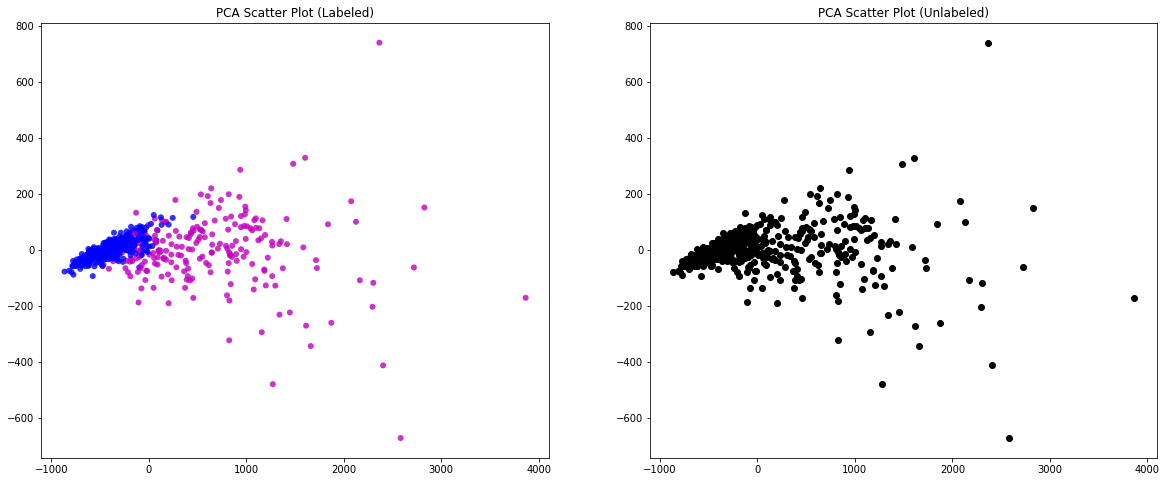

In [17]:
# Plot the PCA visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('PCA Scatter Plot (Labeled)')

plt.subplot(1,2,2)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = 'black')
plt.title('PCA Scatter Plot (Unlabeled)')
plt.show()

In this dataset, we have the benefit of knowing the ground truth and are able to label datapoints according to the target (malignant-M, or benign-B). The labeled graph gives a better sense for how well the classes are seperated from each other, while the unlabeled graph shows how the visual data looks without the labels, serving as a visual measure of distinction between the classes. In other words, the labeled graph provides a visual of accuracy, while the unlabeled graph provides a visual of the effectiveness of generating two classes.

PCA does a decent job of seperating the classes in the labeled plot, however, is mostly unsatisfactory in the unlabeled plot. While one cluster of observations appears to stand out to the left, it is difficult to make a clear dinstinction without the benefit of the ground truth. Essentially, the accuracy looks decent, but the clustering ability is weak.

Perhaps scaling the PCA features will help in this regard. In order to determine the best scaling technique to utilize, let's first get a feel for the distribution of variables in the dataset (are the distributions Gaussian?).

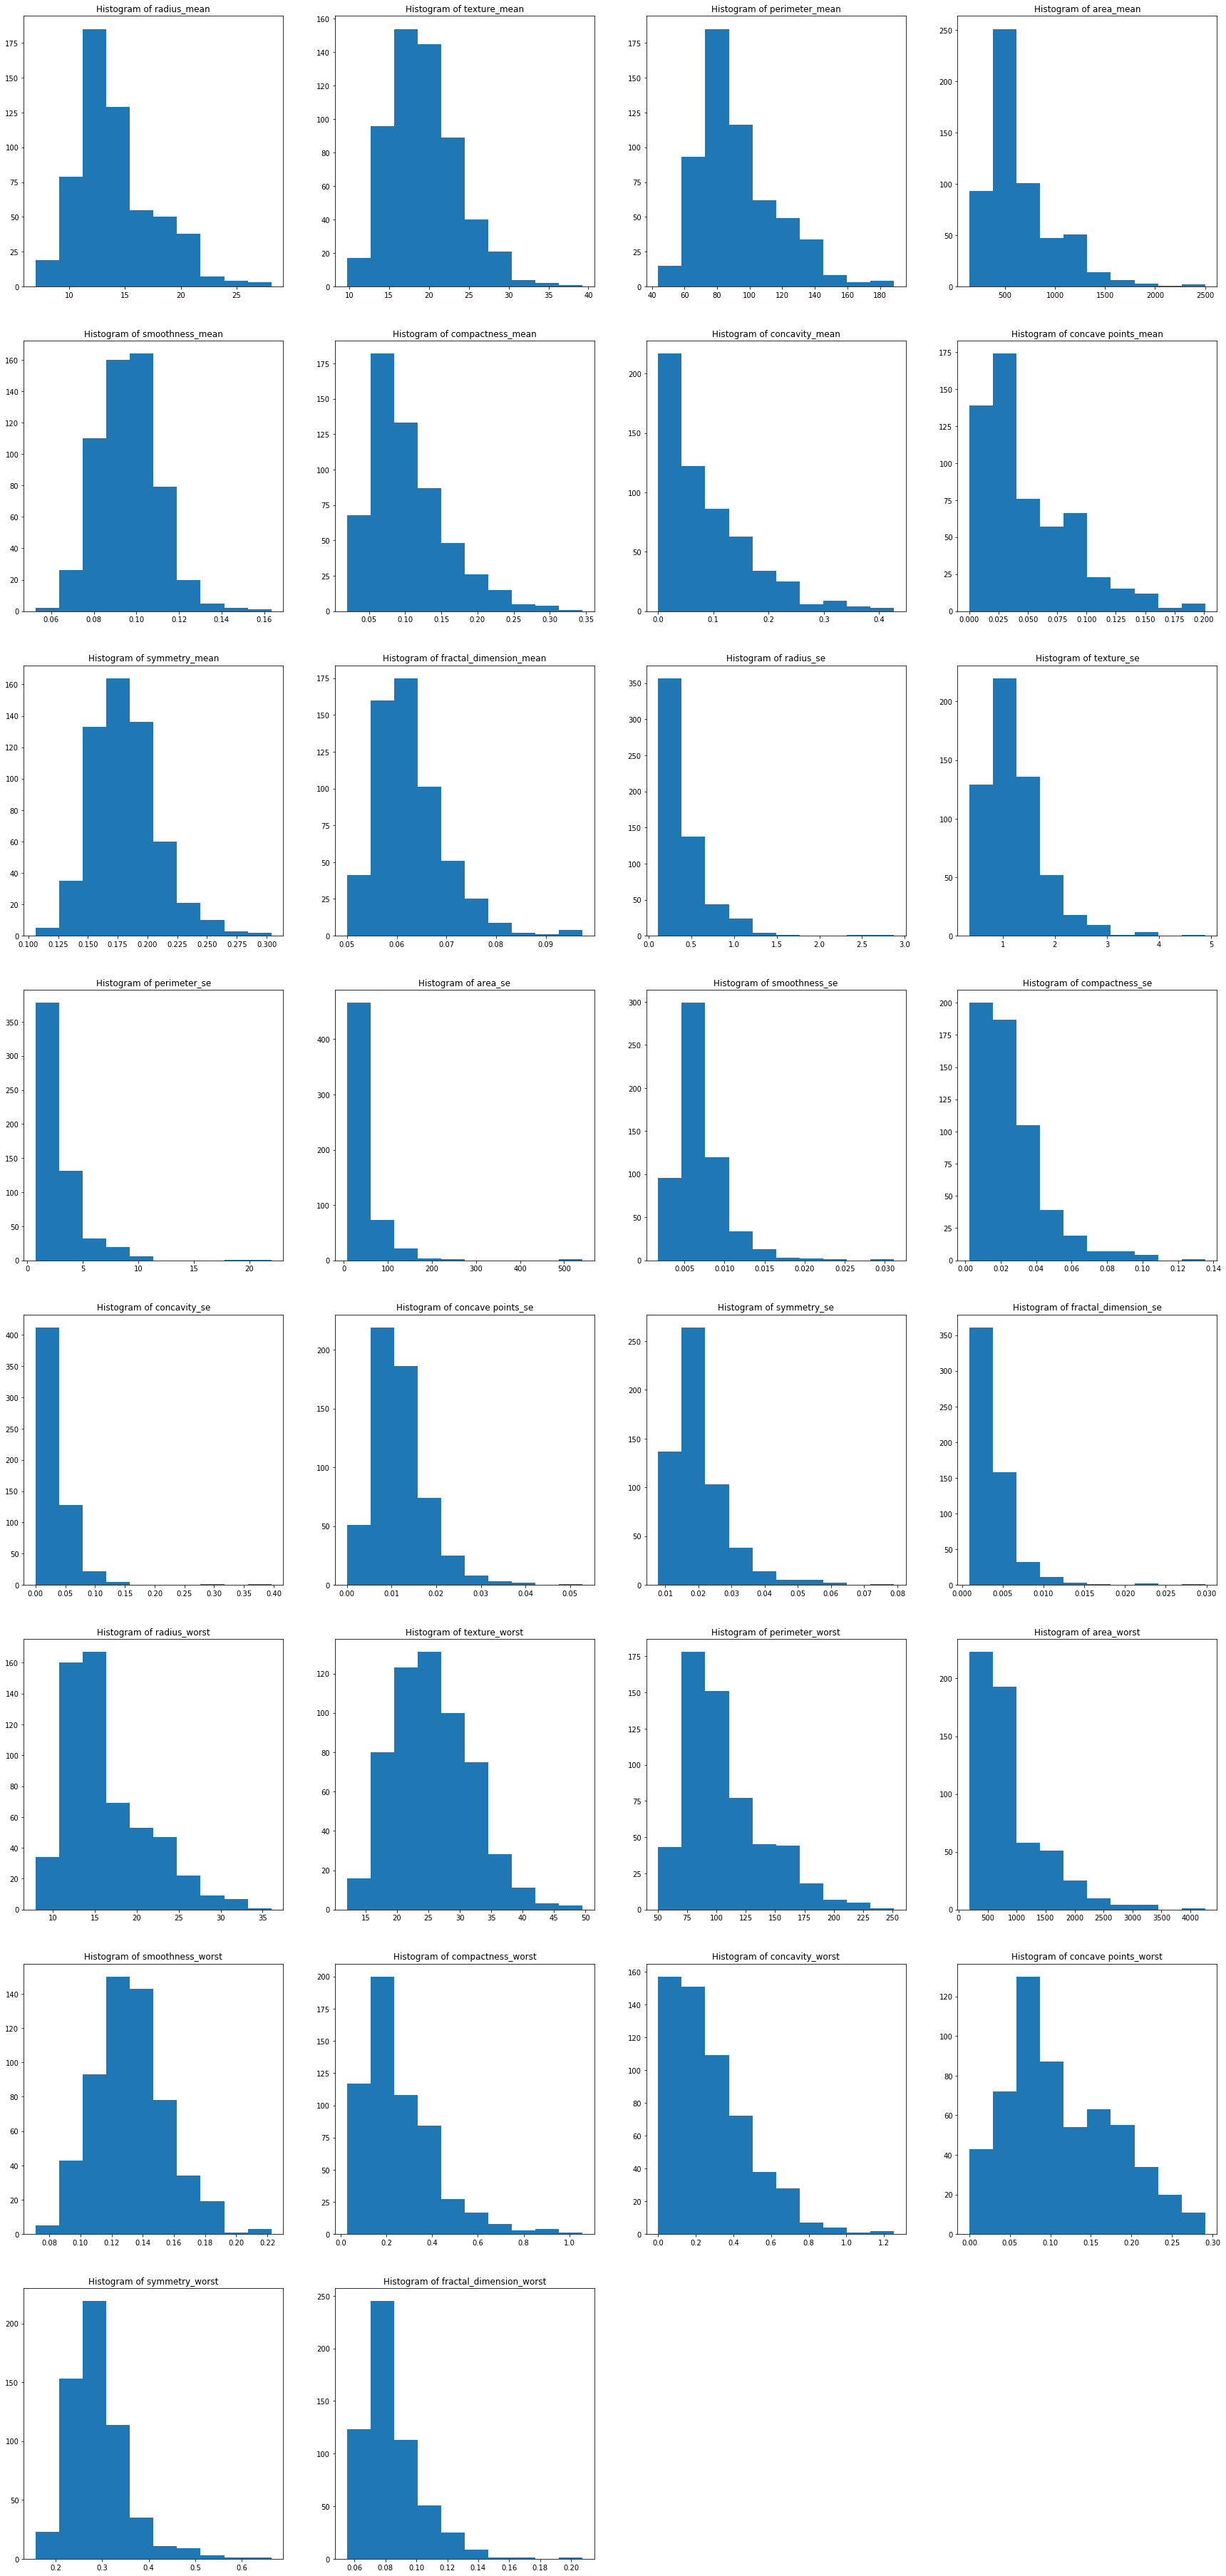

In [18]:
#Visual examination of outliers:
plt.figure(figsize=(30,250))

for i, column in enumerate(fill_list):
    plt.subplot(len(fill_list), 4, i+1)
    plt.hist(df[column])
    plt.title("Histogram of {}".format(column))
    
plt.show()

While some of the distributions are visually somewhat normal (Gaussian), many are not. Therefore, using MinMaxScaler might make more sense than using StandardScaler (link: http://benalexkeen.com/feature-scaling-with-scikit-learn/). However, I will include both scaling techniques to see if one achieves better results than the other.

In [19]:
# Applying MinMaxScaler

from sklearn.preprocessing import MinMaxScaler
X_min_max = MinMaxScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_min_max)

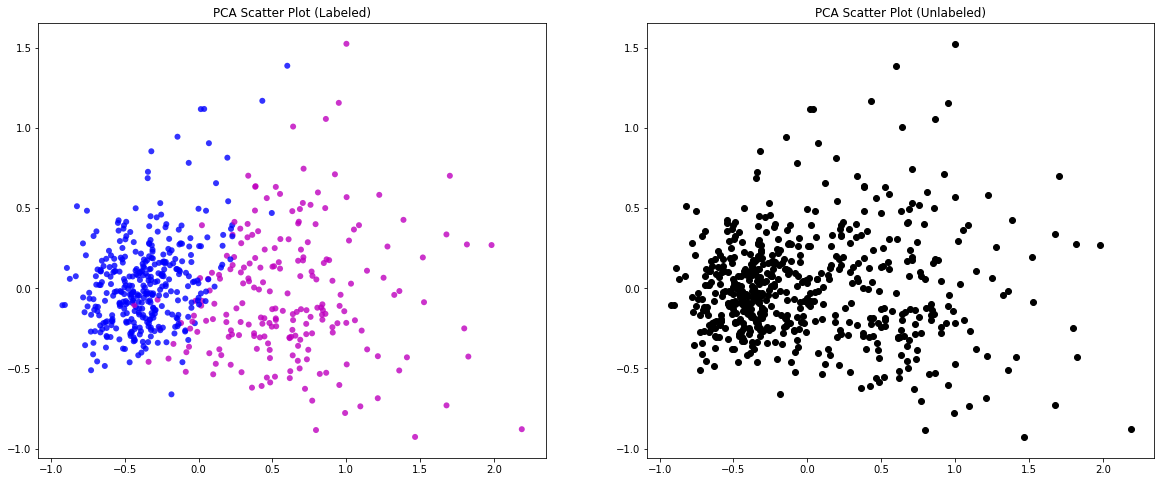

In [20]:
# Plot the PCA visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('PCA Scatter Plot (Labeled)')

plt.subplot(1,2,2)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = 'black')
plt.title('PCA Scatter Plot (Unlabeled)')
plt.show()

The results after applying the MinMaxScaler are a little different. The dense cluster for one class is more spaced out than before, and the other is more condensed. However, these results are still not great, as it is difficult to see two clealy distinct classes in the unlabeled plot.

Now let's try using StandardScaler.

In [21]:
X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X_std)

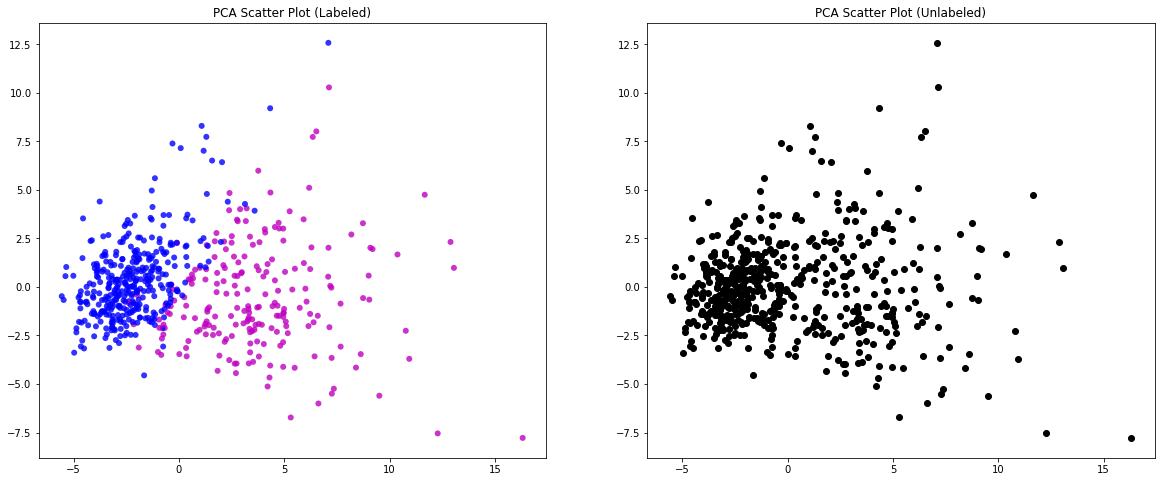

In [22]:
# Plot the PCA visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('PCA Scatter Plot (Labeled)')

plt.subplot(1,2,2)
plt.scatter(pca_2d[:,0],pca_2d[:,1], c = 'black')
plt.title('PCA Scatter Plot (Unlabeled)')
plt.show()

The results of using StandardScaler are pretty much more of the same, though slightly improved on using the MinMaxScaler. The class to the left is a little more distinct (though not as distinct as it was without scaling), and the class on the right is perhaps a little more condensed, but is still intertwined with the other class, especially when looking at the unlabeled plot.

Overall, scaling techniques may have marginally improved the results, but for this dataset PCA does not look like a great dimensionality technique in terms of visually showing local similarities, and generating two distinct classes.

_t-Distributed Stochastic Neighbor Embedding (t-SNE)_

Next up is t-SNE, which is a dimensionality reduction technique known for its effectiveness in preserving local similarities in the data. Logically, this should work better than PCA for this dataset.

In [23]:
# Invoke the TSNE method
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 33.679705
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.852917
[t-SNE] KL divergence after 2000 iterations: 0.217912
Time elapsed: 4.961731910705566 seconds


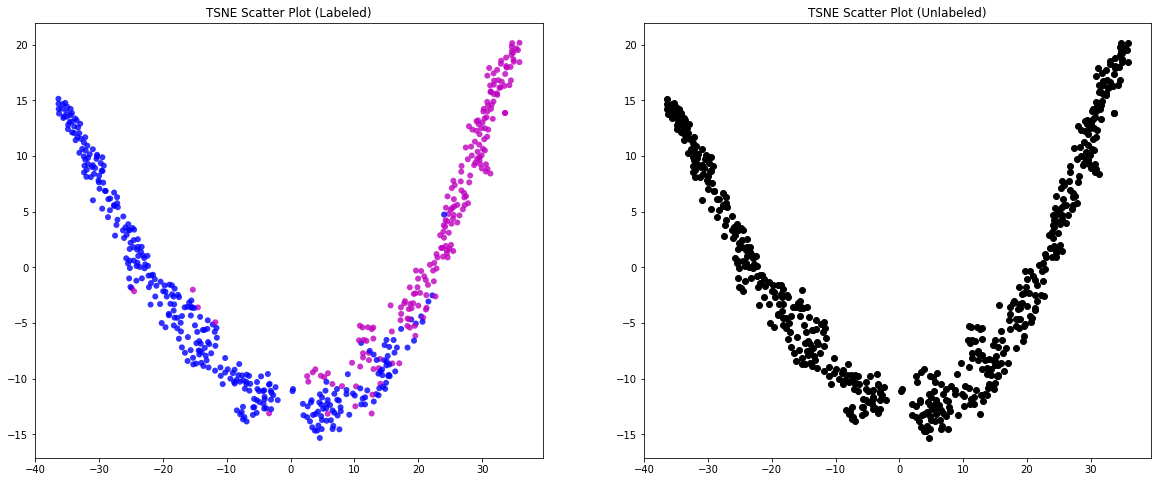

In [24]:
# Plot the t_SNE visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('TSNE Scatter Plot (Labeled)')

plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = 'black')
plt.title('TSNE Scatter Plot (Unlabeled)')
plt.show()

Initially, the t-SNE dimensionality reduction technique appears to be pretty effective at distinguishing two different classes, and is the better option over PCA. However, while comparing the labeled and unlabeled scatter plots, one can see that it would be easy to mistake part of one of the classes as part of the other. This is excellent at generating two distinct classes, but the accuracy could perhaps be better.

Changing the perplexity hyperparameter may help this issue (suggested range is between 5 and 50).

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 16.685256
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.145679
[t-SNE] KL divergence after 2000 iterations: 0.413518
Time elapsed: 3.7270350456237793 seconds


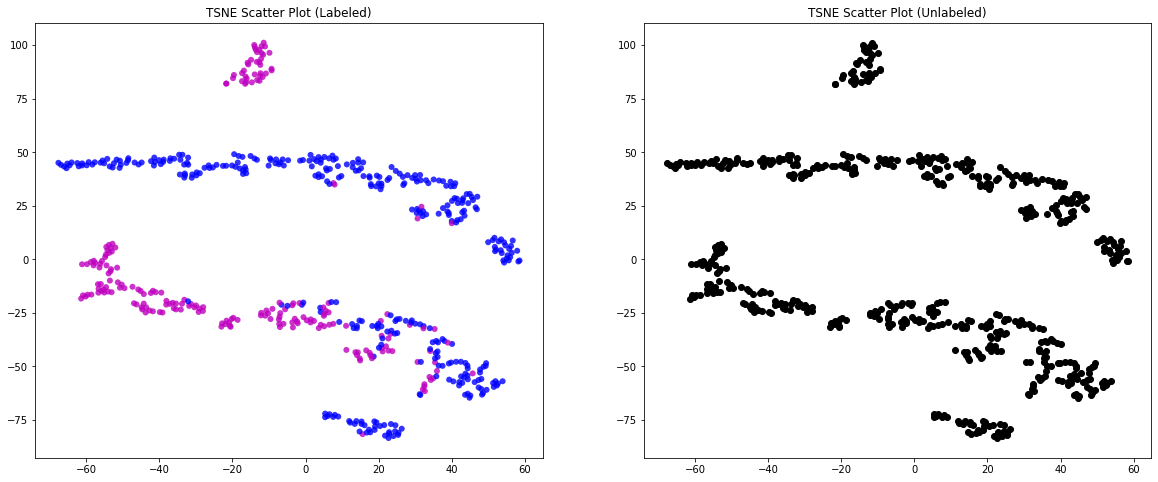

In [25]:
# Perplexity = 10
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=2000)
tsne_results = tsne.fit_transform(X)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

# Plot
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('TSNE Scatter Plot (Labeled)')
plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = 'black')
plt.title('TSNE Scatter Plot (Unlabeled)')
plt.show()

Lowering perplexity to 10 has a negative impact, as you can no longer make out two distinct classes.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 29.003688
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.209419
[t-SNE] KL divergence after 2000 iterations: 0.248660
Time elapsed: 4.330421447753906 seconds


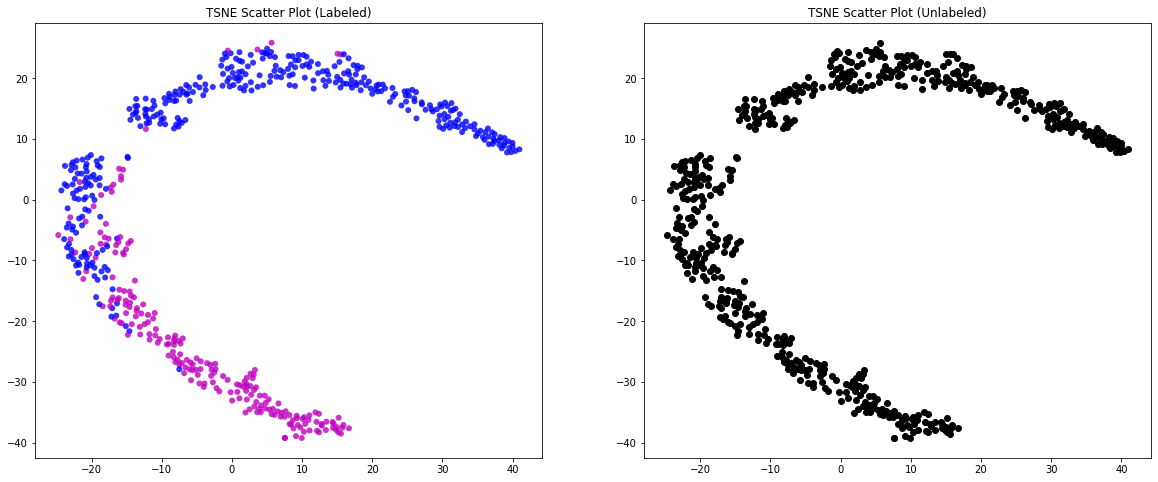

In [26]:
# Perplexity = 30
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=2000)
tsne_results = tsne.fit_transform(X)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

# Plot
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('TSNE Scatter Plot (Labeled)')
plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = 'black')
plt.title('TSNE Scatter Plot (Unlabeled)')
plt.show()

This result is similar to the original plot, where perplexity = 40. There is no obvious improvement here, as there are two distinct classes, but with some error in overlap (which would not be noticeable without the benefit of labels).

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 37.730326
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.732159
[t-SNE] KL divergence after 2000 iterations: 0.190489
Time elapsed: 5.212107181549072 seconds


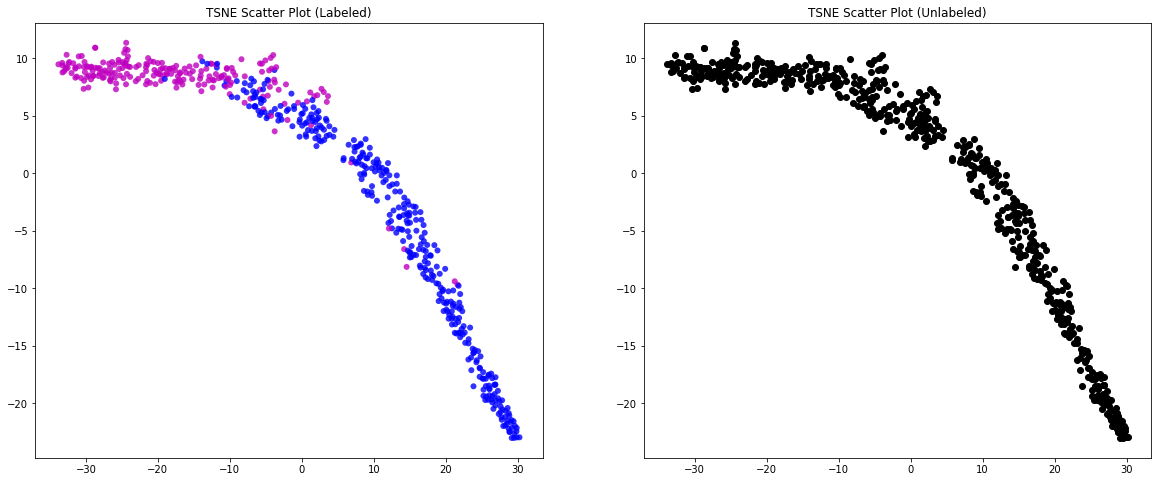

In [27]:
# Perplexity = 50
time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=2000)
tsne_results = tsne.fit_transform(X)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

# Plot
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('TSNE Scatter Plot (Labeled)')
plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = 'black')
plt.title('TSNE Scatter Plot (Unlabeled)')
plt.show()

While overlapping of classes is perhaps somewhat reduced, the clear dinstinction between classes comes as its cost. Therefore, the orginal perplexity value still appears to be the best.

Using scaling techniques may present a better alternative.

In [28]:
X_min_max = MinMaxScaler().fit_transform(X)

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X_min_max)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 0.215072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.662109
[t-SNE] KL divergence after 1900 iterations: 0.888649
Time elapsed: 5.287094354629517 seconds


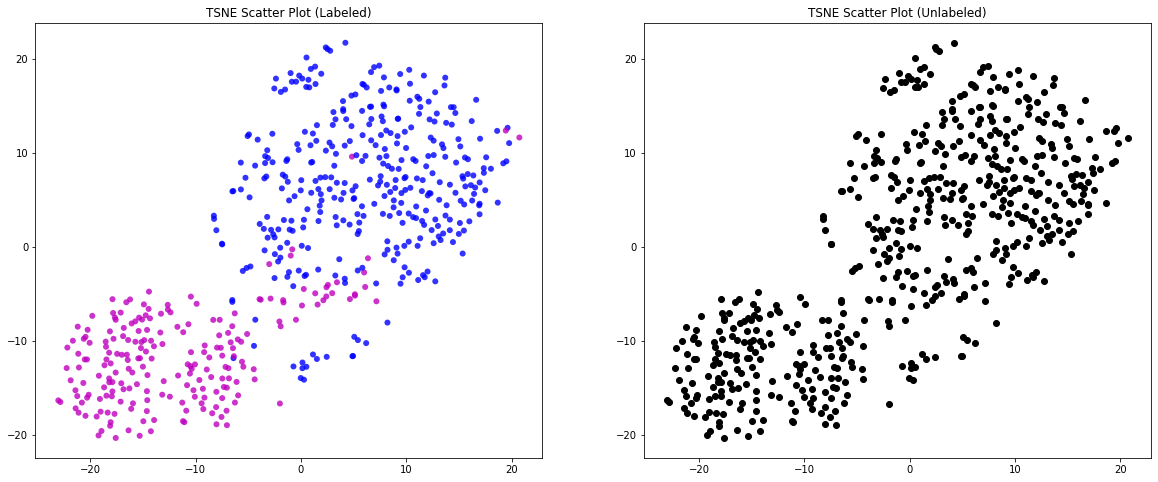

In [29]:
# Plot the t_SNE visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('TSNE Scatter Plot (Labeled)')

plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = 'black')
plt.title('TSNE Scatter Plot (Unlabeled)')
plt.show()

This solution may the best so far, as there is little overlap between the two classes (see labeled plot), and there are two pretty distinct classes (see unlabeled plot). Accuracy is better here than it was without scaling the data.

In [30]:
X_std = StandardScaler().fit_transform(X)

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X_std)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.522404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.915421
[t-SNE] KL divergence after 1750 iterations: 0.885517
Time elapsed: 5.1561174392700195 seconds


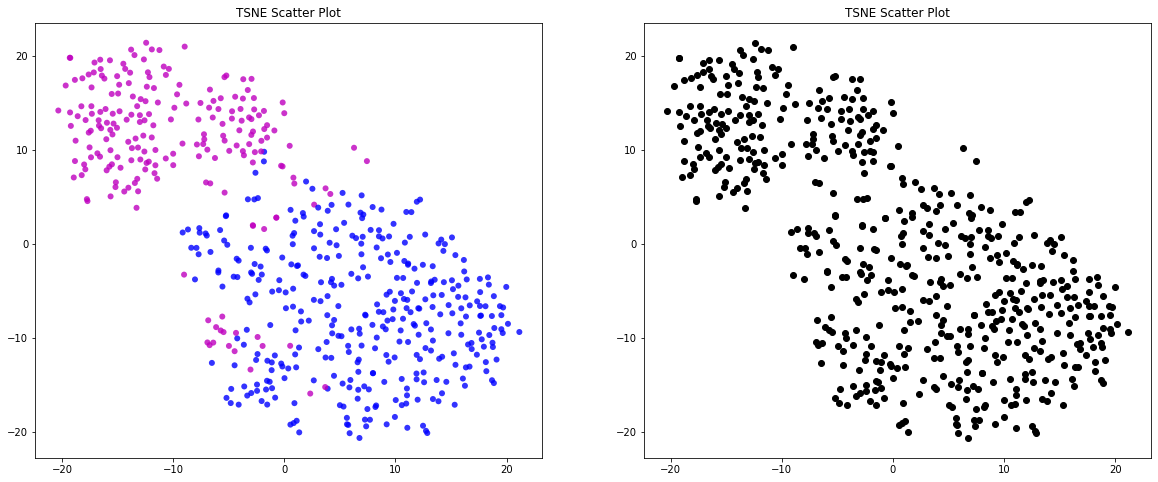

In [31]:
# Plot the t_SNE visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('TSNE Scatter Plot')

plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = 'black')
plt.title('TSNE Scatter Plot')
plt.show()

The results using StandardScaler are similar to the results of the MinMaxScaler. It's difficult to say if one proves better than the other.

Overall, t-SNE is clearly the better dimensionality reduction technique over PCA, in this instance. Scaling (using either MinMaxScaler or StandardScaler) improves accuracy, without the cost of being able to clearly distinguish two classes.

_Uniform Manifold Approximation and Projection (UMAP)_

The last dimensionality reduction technique for consideration here is UMAP, which is has similar success to t-SNE at producing low-dimensional representations, but at a much faster speed. t-SNE only took approximately 6 seconds, so time isn't necessarily the biggest factor in this instance, however, it is worth consideration if UMAP can produce similar results.

In [32]:
!pip install umap-learn
import umap

In [33]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

Time elapsed: 3.461676836013794 seconds


UMAP is indeed a little quicker than t-SNE, coming in at approximately 3.5 seconds.

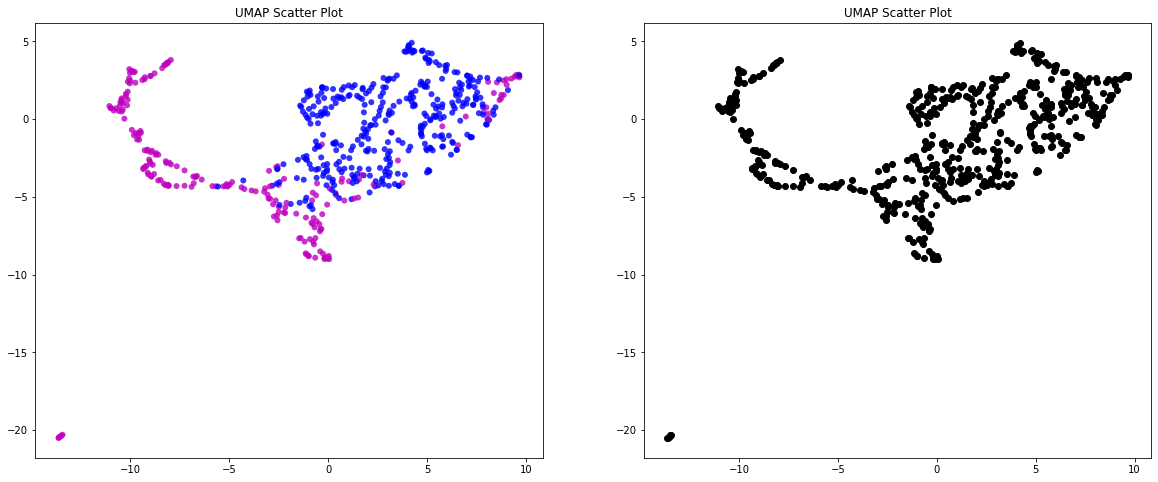

In [34]:
# Plot the UMAP visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(umap_results[:,0],umap_results[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('UMAP Scatter Plot')

plt.subplot(1,2,2)
plt.scatter(umap_results[:,0],umap_results[:,1],  c = 'black')
plt.title('UMAP Scatter Plot')
plt.show()

This reduction technique looks promising, as accuracy of labeled observations (labeled plot) looks good. However, as seen in the unlabeled graph, making out two distinct classes is less obvious as there is no linear seperation between classes. In addition, the shape of the clusters could lead to the conclusion that there are more than two classes in this dataset.

Tuning the hyperparameters may improve these results.

C:\ProgramData\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


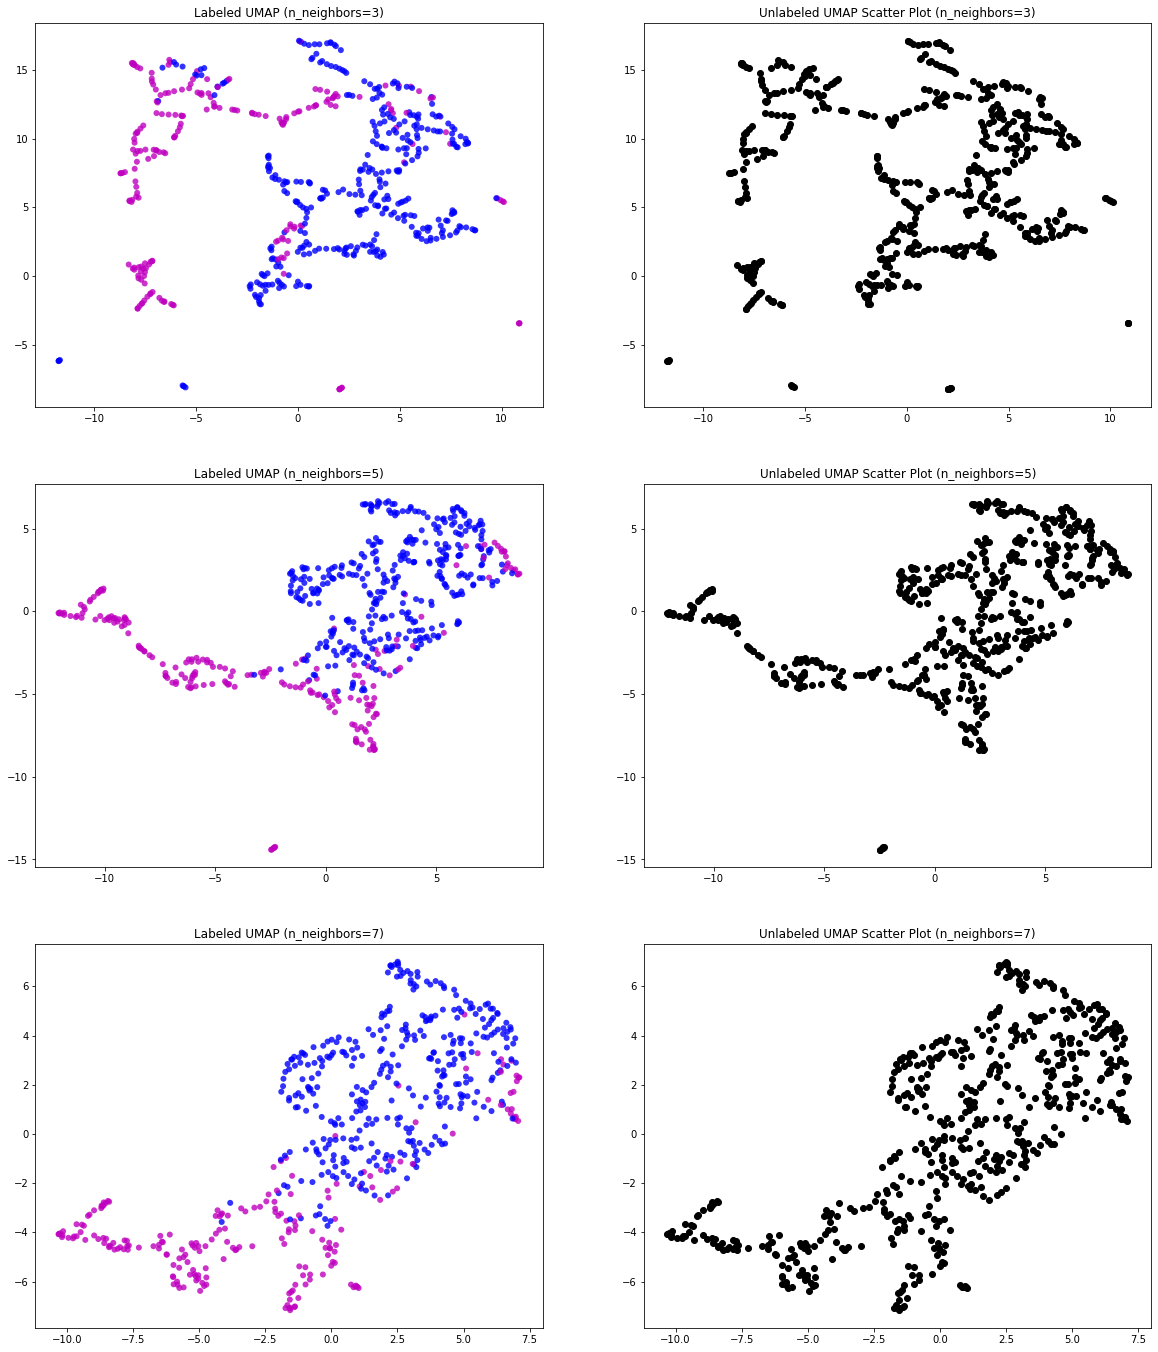

In [35]:
# n_neighbors=3
umap_nn3 = umap.UMAP(n_neighbors=3,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)
# n_neighbors=5
umap_nn5 = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)
# n_neighbors=7
umap_nn7 = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)


plt.figure(figsize = (20,24))
plt.subplot(3,2,1)
plt.scatter(umap_nn3[:,0],umap_nn3[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('Labeled UMAP (n_neighbors=3)')

plt.subplot(3,2,2)
plt.scatter(umap_nn3[:,0],umap_nn3[:,1],  c = 'black')
plt.title('Unlabeled UMAP Scatter Plot (n_neighbors=3)')

plt.subplot(3,2,3)
plt.scatter(umap_nn5[:,0],umap_nn5[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('Labeled UMAP (n_neighbors=5)')

plt.subplot(3,2,4)
plt.scatter(umap_nn5[:,0],umap_nn5[:,1],  c = 'black')
plt.title('Unlabeled UMAP Scatter Plot (n_neighbors=5)')

plt.subplot(3,2,5)
plt.scatter(umap_nn7[:,0],umap_nn7[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('Labeled UMAP (n_neighbors=7)')

plt.subplot(3,2,6)
plt.scatter(umap_nn7[:,0],umap_nn7[:,1],  c = 'black')
plt.title('Unlabeled UMAP Scatter Plot (n_neighbors=7)')


plt.show()

Of these three different values for n_neighbors, 5 or 7 appears to be the best. Let's see how changing another parameter (min_dist) and keeping n_neighbors as 5 looks.

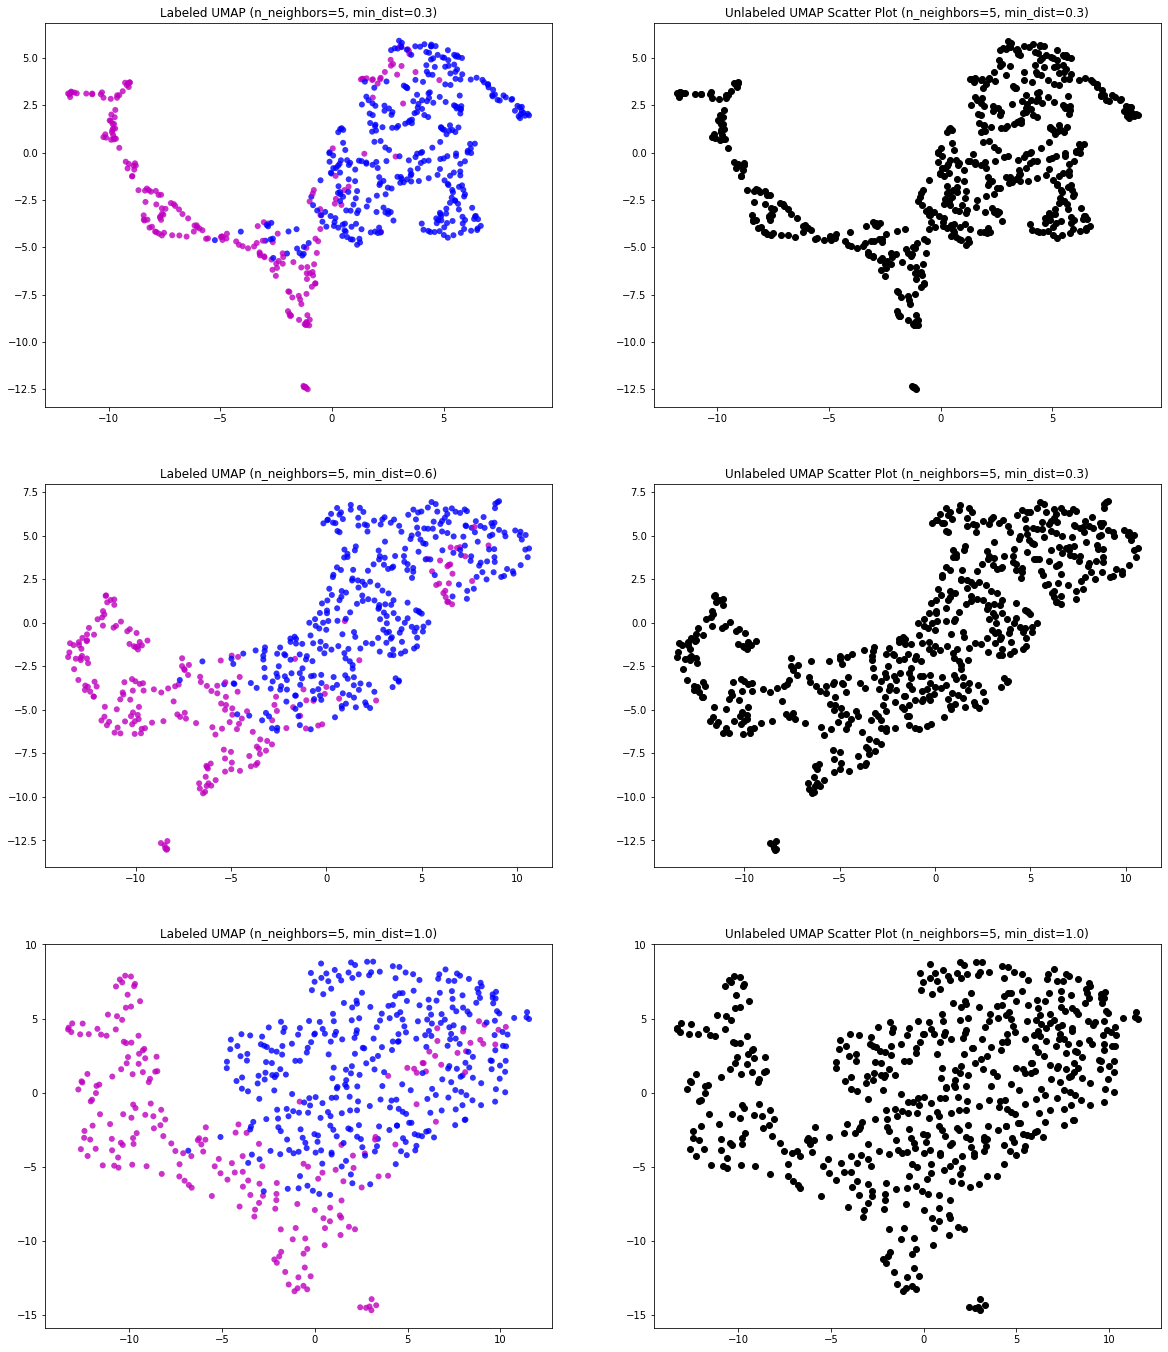

In [36]:
# min_dist=0.3
umap_md03 = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)
# min_dist=0.6
umap_md06 = umap.UMAP(n_neighbors=5,
                      min_dist=0.6,
                      metric='correlation').fit_transform(X)
# min_dist=1
umap_md10 = umap.UMAP(n_neighbors=5,
                      min_dist=1,
                      metric='correlation').fit_transform(X)


plt.figure(figsize = (20,24))
plt.subplot(3,2,1)
plt.scatter(umap_md03[:,0],umap_md03[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('Labeled UMAP (n_neighbors=5, min_dist=0.3)')

plt.subplot(3,2,2)
plt.scatter(umap_md03[:,0],umap_md03[:,1],  c = 'black')
plt.title('Unlabeled UMAP Scatter Plot (n_neighbors=5, min_dist=0.3)')

plt.subplot(3,2,3)
plt.scatter(umap_md06[:,0],umap_md06[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('Labeled UMAP (n_neighbors=5, min_dist=0.6)')

plt.subplot(3,2,4)
plt.scatter(umap_md06[:,0],umap_md06[:,1],  c = 'black')
plt.title('Unlabeled UMAP Scatter Plot (n_neighbors=5, min_dist=0.3)')

plt.subplot(3,2,5)
plt.scatter(umap_md10[:,0],umap_md10[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('Labeled UMAP (n_neighbors=5, min_dist=1.0)')

plt.subplot(3,2,6)
plt.scatter(umap_md10[:,0],umap_md10[:,1],  c = 'black')
plt.title('Unlabeled UMAP Scatter Plot (n_neighbors=5, min_dist=1.0)')


plt.show()

The UMAP dimensionality reduction technique with n_neighbors=5 and min_dist=0.6 (or min_dist=1.0) appears to be better than PCA, but worse than t-SNE. There are two obvious classes when looking at the unlabeled plot, as suspected, and there is little overlap between the classes. However, there is little seperation between classes and making out two distinct classes is not as obvious as it was with t-SNE.

For the sake of thoroughness, we can apply scaling techniques as well, to see if we can achieve better results.

In [37]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.6,
                      metric='correlation').fit_transform(X_min_max)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

Time elapsed: 0.5677111148834229 seconds


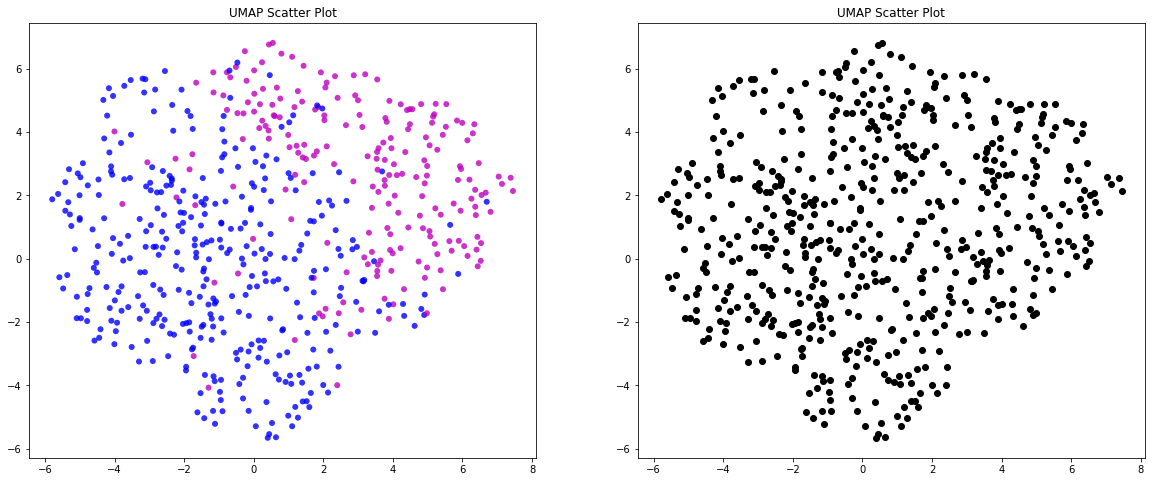

In [38]:
# Plot the UMAP visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(umap_results[:,0],umap_results[:,1],  c = target, 
            cmap = "coolwarm", edgecolor = "None", alpha=.8)
plt.title('UMAP Scatter Plot')

plt.subplot(1,2,2)
plt.scatter(umap_results[:,0],umap_results[:,1],  c = 'black')
plt.title('UMAP Scatter Plot')
plt.show()

In [39]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

print('Time elapsed: {} seconds'.format(time.time()-time_start))

Time elapsed: 0.5771963596343994 seconds


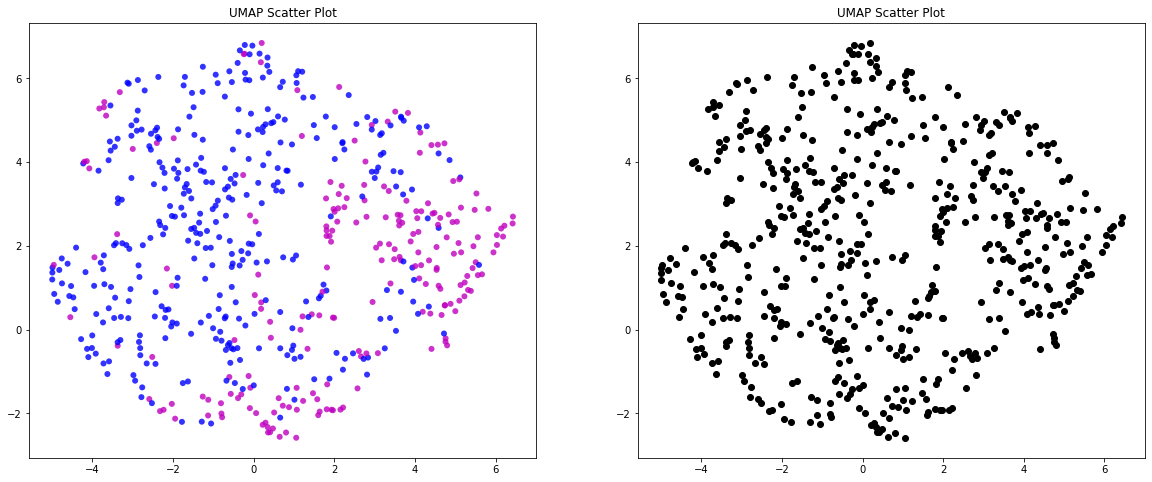

In [40]:
# Plot the UMAP visuals
plt.figure(figsize = (20,8))

plt.subplot(1,2,1)
plt.scatter(umap_results[:,0],umap_results[:,1],  c = target, 
            cmap = "coolwarm", edgecolor = "None", alpha=.8)
plt.title('UMAP Scatter Plot')

plt.subplot(1,2,2)
plt.scatter(umap_results[:,0],umap_results[:,1],  c = 'black')
plt.title('UMAP Scatter Plot')
plt.show()

For either scaling technique, the results of applying that scaling technique to the UMAP dimensionality reduction method are far from satisfactory. A quick look at the unlabeled plots will reveal that there are no distinct classes.

UMAP with n_neighbors=5 and min_dist=.6 without any scaling is a decent solution. This solution shows accuracy among two classes (malignant, and benign) when labeled, however, doesn't really form two distinct classes (not linearly seperable).

However, t-SNE dimensionality reduction technnqiue using StandardScaler also achieved very strong results, and is the best solution presented here. Accuracy is high, and two visually distinct classes can be seen. In addition, this technique may prove more useful when applied to clustering techniques, as we will see below.

The t-SNE dimensionality reduction method will be applied as appropriate in building a unsupervised model for clustering.

### Building models: Clustering algorithms

The following clustering techniques will be used to build a model: K-means, Hierarchical, DBSCAN, and GMM.

_K-means_

Prerequisites for k-means include: cluster number is k, clusters are isotropic, and all clusters have similar variance. In order to use k-means, we can apply to t-SNE dimensionality technnqiue using StandardScaler to best match these prerequisites.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 569 samples in 0.001s...
[t-SNE] Computed neighbors for 569 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 569 / 569
[t-SNE] Mean sigma: 1.522404
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.043991
[t-SNE] KL divergence after 1950 iterations: 0.887548


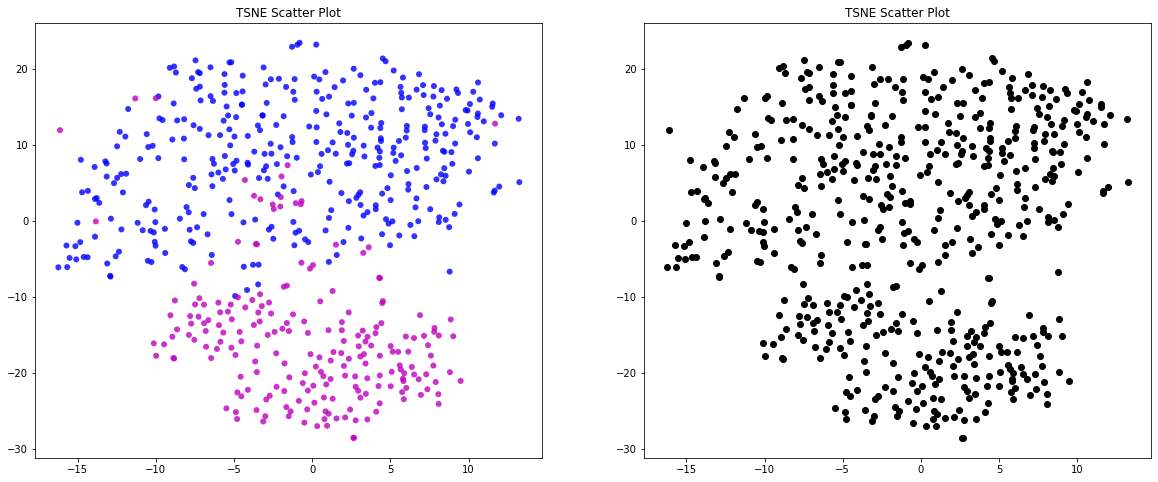

In [41]:
#X_std = StandardScaler().fit_transform(X)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X_std)

# Plot the t_SNE visuals
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = target, 
            cmap = "seismic", edgecolor = "None", alpha=.8)
plt.title('TSNE Scatter Plot')
plt.subplot(1,2,2)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  c = 'black')
plt.title('TSNE Scatter Plot')
plt.show()

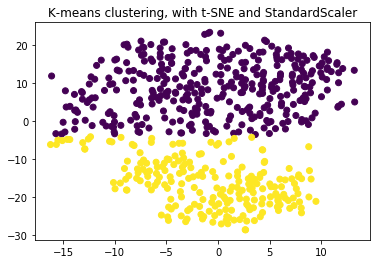

In [42]:
# Apply k-means
k_means = KMeans(n_clusters=2, random_state=123).fit_predict(tsne_results)

# Plot
plt.title("K-means clustering, with t-SNE and StandardScaler")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c = k_means)
plt.show()

This solution looks very good. K-means predicts two distinct, viable clusters.

In [43]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(k_means, target))

Comparing k-means clusters against the data:
diagnosis    B    M
row_0              
0          331   22
1           26  190


Using Pandas crosstab (possible with the ground truth available) for a contingency table, we are able to examine the accuracy of these clusters. There are only 46 errors out of 569 cases, meaning this is performing very well!

In [44]:
print("ARI score: {}".format(metrics.adjusted_rand_score(target, k_means)))
print("Silhouette score: {}".format(metrics.silhouette_score(tsne_results, k_means, metric='euclidean')))

ARI score: 0.6893802548888883
Silhouette score: 0.5282698273658752


In addition, we can evaluate the K-means model using the Adjusted Rand Index (ARI score), which is the ratio of number of pairs where the ground truth and the new solution agree over the total number of pairs (scores range from 0 to 1). The ARI score for this solution is high at .69. Now let's look at the silhouette score.

The silhouette score is a way of computing similarity when the ground truth is not available (no labels available). The silhouette score evaluates the mean of all silhouette coefficients (mean distance b/w a datapoint and all other points in its cluster + mean distance between that datapoint and all other points in the nearest other cluster, divided by highest of the two values). It is essentially a measure of whether or not a datapoint is more similar to its assigned cluster, or not (range of -1, very bad, to 1, perfect). The silhouette score for this solution is 0.53, which is pretty good. Points in each cluster are more similar to other points in the same cluster than another cluster.

_Hierarchical (Agglomerative) clustering_

We can use dendrograms to visualize different linkage methods for agglomerative clustering.

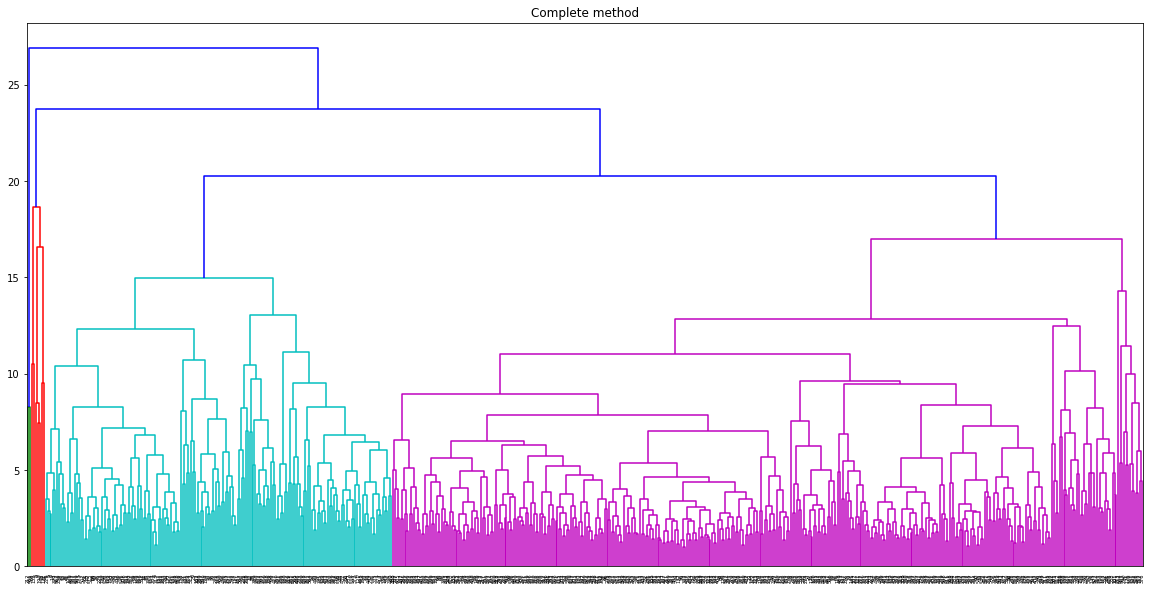

In [45]:
# Dendrogram with 'complete' linkage method
plt.figure(figsize=(20,10))
plt.title("Complete method")
dendrogram(linkage(X_std, method='complete'))
plt.show()

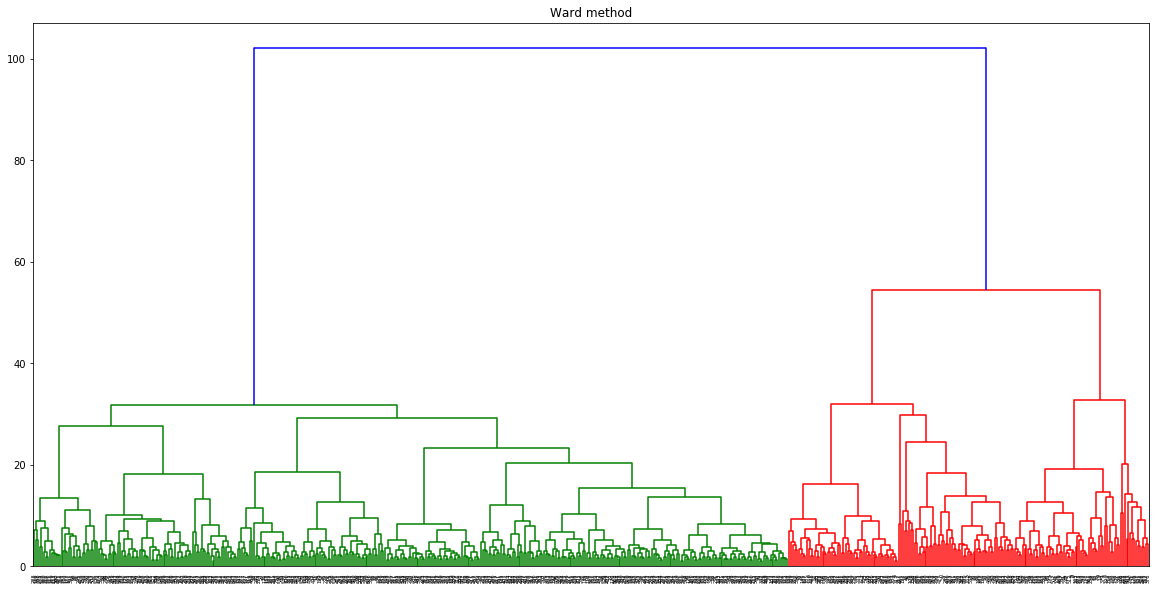

In [46]:
# Dendrogram with 'ward' linkage method
plt.figure(figsize=(20,10))
plt.title("Ward method")
dendrogram(linkage(X_std, method='ward'))
plt.show()

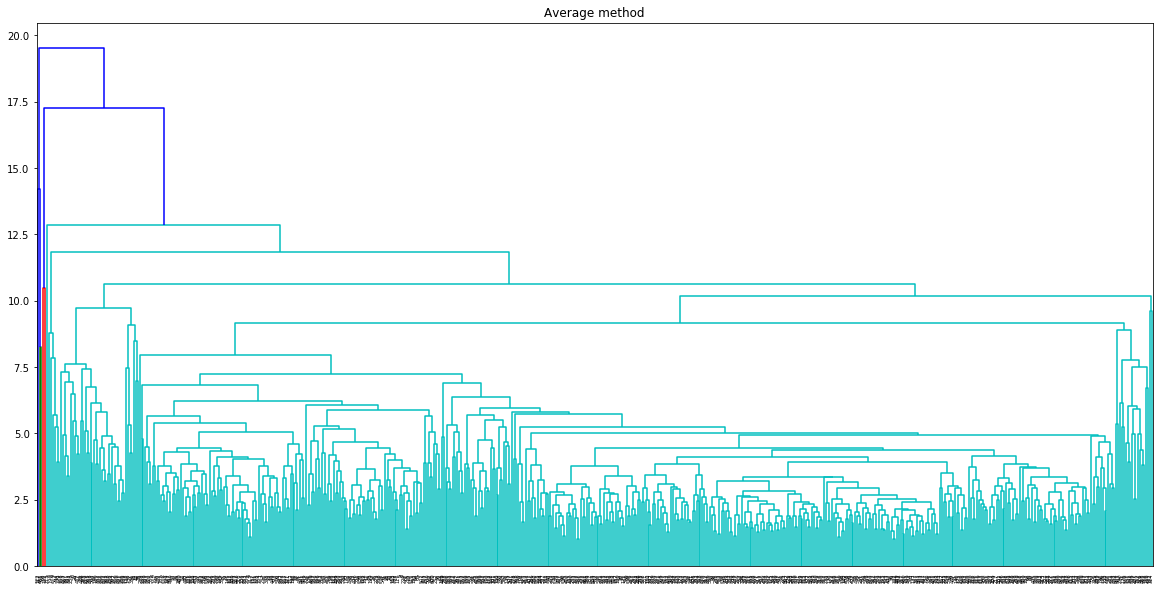

In [47]:
# Dendrogram with 'average' linkage method
plt.figure(figsize=(20,10))
plt.title("Average method")
dendrogram(linkage(X_std, method='average'))
plt.show()

The ward linkage method produces two clear clusters, and appears to be the best linkage method to use here. Now we can use ARI and silhouette scores as a statistical metric.

In [48]:
complete_linkage = AgglomerativeClustering(
    linkage='complete',
    affinity='euclidean',
    n_clusters=2
)

average_linkage = AgglomerativeClustering(
    linkage='average',
    affinity='euclidean',
    n_clusters=2
)

ward_linkage = AgglomerativeClustering(
    linkage='ward',
    affinity='euclidean',
    n_clusters=2
)

#Fit models
complete_cluster = complete_linkage.fit_predict(X_std)
average_cluster = average_linkage.fit_predict(X_std)
ward_cluster = ward_linkage.fit_predict(X_std)

#Get scores
complete_ari = metrics.adjusted_rand_score(target, complete_cluster)
complete_sc = metrics.silhouette_score(X_std, complete_cluster, metric='euclidean')

average_ari = metrics.adjusted_rand_score(target, average_cluster)
average_sc = metrics.silhouette_score(X_std, average_cluster, metric='euclidean')


ward_ari = metrics.adjusted_rand_score(target, ward_cluster)
ward_sc = metrics.silhouette_score(X_std, ward_cluster, metric='euclidean')


print("ARI score and silhouette scores")
print("Agglomerative(complete): {}, {})".format(complete_ari, complete_sc))
print("Agglomerative(average): {}, {})".format(average_ari, average_sc))
print("Agglomerative(ward): {}, {})".format(ward_ari, ward_sc))

ARI score and silhouette scores
Agglomerative(complete): 0.004828344696591908, 0.6606668813897673)
Agglomerative(average): 0.007276182817303723, 0.6339782218419878)
Agglomerative(ward): 0.5750409366326297, 0.33938477753669855)


While the silhouette scores are highest for the complete and average linkage methods, it is important to remember the results of the dendrogram. The silhouette score for the ward method for the ward method was also strong at 0.34, and the dendrogram formed two clear clusters. For this reason, the ward linkage method should be selected over the other two, before we even account for the ARI scores. The ARI score was essentially zero for the complete and average linkage methods, but was pretty high for the ward linkage method at 0.58.

While agglomerative clustering using the ward linkage method scores pretty high, the k-means solution still out-performs it with an ARI score of .69 and silhouette score of 0.53.

In [49]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(ward_cluster, target))

Comparing k-means clusters against the data:
diagnosis    B    M
row_0              
0           20  164
1          337   48


This confirms the results of the ARI and silhouette scores. The agglomerative clustering solution (ward linkage) performs well, but slightly worse than the k-means solution with 68 errors (compared to 48).

_Density-based spatial clustering of applications with noise (DBSCAN)_

In [50]:
#Create a function that builds model and outputs a plot
def dbscan_cluster(eps, min_samples, X_std):
    #Fit model using parameters
    parameters = {
        'eps': eps,
        'min_samples': min_samples
    }
    dbscan = DBSCAN(**parameters).fit_predict(tsne_results)

    plt.title("DBSCAN clustering")
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c = dbscan)
    plt.show()

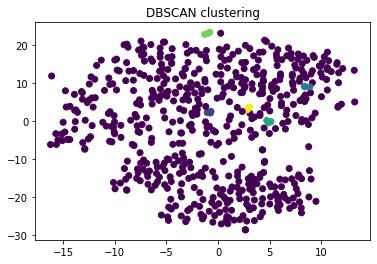

In [51]:
dbscan_cluster(.5, 3, X_std)

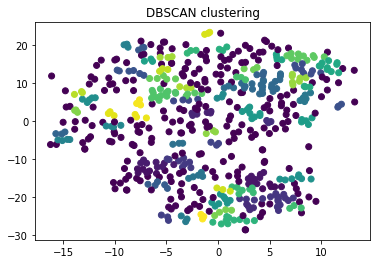

In [52]:
dbscan_cluster(1, 3, X_std)

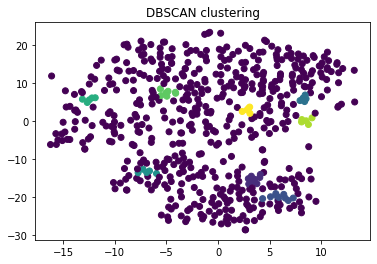

In [53]:
dbscan_cluster(1, 5, X_std)

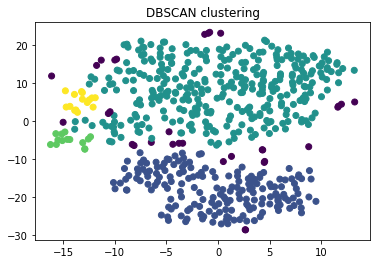

In [54]:
dbscan_cluster(2, 5, X_std)

Getting the right hyperparameters for DBSCAN can be tricky, however, epsilon=2 and min_samples=5 proved to be decent, visually speaking. However, there is more than two clusters present. Evaluating this solution statistically will help make sense of how this solution compares to the others.

In [55]:
dbscan = DBSCAN(eps=2, min_samples=5).fit_predict(tsne_results)

print("ARI score: {}".format(metrics.adjusted_rand_score(target, dbscan)))
print("Silhouette score: {}".format(metrics.silhouette_score(tsne_results, dbscan, metric='euclidean')))

ARI score: 0.6255320251137062
Silhouette score: 0.24308693408966064


The final results of DBSCAN are pretty decent, although K-means remains the best solution. The ARI score is similar to K-Means, but is a little lower at 0.63 (compared to 0.69). However, the silhouette score (.24) is lower than K-Means(.54). The silhouette score could be due to the higher number of clusters for DBSCAN, which is another drawback. The silhouette score is also lower than that of agglomerative/hierarchical clustering solutions.

In [56]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(dbscan, target))

Comparing k-means clusters against the data:
diagnosis    B    M
row_0              
-1          19   13
 0           3  177
 1         306   22
 2          14    0
 3          15    0


The most important metrics in answering our research question are visual data (forming two distinct clusters) and the silhouette scores (a measure of similarity among observations in each cluster). Therefore, K-means remains the best model.

_Gaussian Mixture Model (GMM)_

We can apply different covariance parameters (full, tied, diag, and spherical) to select the best solution for GMM.

In [57]:
# FULL (DEFAULT)

# Define clustering with GMM
gmm_cluster = GaussianMixture(n_components=2,
                              covariance_type='full',
                              random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

# ARI and silhouette scores
print("Adjusted Rand Index of the GMM solution: {}".format(metrics.adjusted_rand_score(target, clusters)))
print("The silhouette score of the GMM solution: {}".format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the GMM solution: 0.7740159832538671
The silhouette score of the GMM solution: 0.31448870991364997


In [58]:
# TIED

# Define clustering with GMM
gmm_cluster = GaussianMixture(n_components=2,
                              covariance_type='tied',
                              random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

# ARI and silhouette scores
print("Adjusted Rand Index of the GMM solution: {}".format(metrics.adjusted_rand_score(target, clusters)))
print("The silhouette score of the GMM solution: {}".format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the GMM solution: 0.693181756002848
The silhouette score of the GMM solution: 0.3304944348118079


In [59]:
# DIAG

# Define clustering with GMM
gmm_cluster = GaussianMixture(n_components=2,
                              covariance_type='diag',
                              random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

# ARI and silhouette scores
print("Adjusted Rand Index of the GMM solution: {}".format(metrics.adjusted_rand_score(target, clusters)))
print("The silhouette score of the GMM solution: {}".format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the GMM solution: 0.6779411384513467
The silhouette score of the GMM solution: 0.3157033751443474


In [60]:
# SPHERICAL

# Define clustering with GMM
gmm_cluster = GaussianMixture(n_components=2,
                              covariance_type='spherical',
                              random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

# ARI and silhouette scores
print("Adjusted Rand Index of the GMM solution: {}".format(metrics.adjusted_rand_score(target, clusters)))
print("The silhouette score of the GMM solution: {}".format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the GMM solution: 0.5506740594726516
The silhouette score of the GMM solution: 0.31000307519661385


The covariance type with the highest ARI and silhouette scores is full (the default), as the ARI score is the highest and all silhouette scores are in a similar range.

Let's visualize this solution.

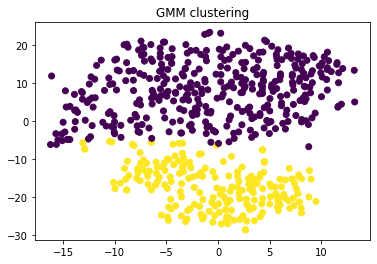

In [61]:
gmm_cluster = GaussianMixture(n_components=2, random_state=123)
gmm = gmm_cluster.fit_predict(tsne_results)

plt.title("GMM clustering")
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c = gmm)
plt.show()

Visually, the GMM solution creates two very dinstinct clusters, making this another viable solution. However, K-means still evaluates a little better statistically, as measured by the ARI and silhouette scores.

In [62]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(gmm, target))

Comparing k-means clusters against the data:
diagnosis    B    M
row_0              
0          344   25
1           13  187


There are only 38 errors shown in the contingency table, which performs closely to the K-means model. However, given that the ARI scores and number of errors are similar for the two solutions, the K-means solution still remains the best because it has a significantly higher silhouette score of 0.54, compared to 0.31.

### Conclusion

The goal of this project was to answer the following research question: can clustering techniques be used to find a distinction between benign and malignant tumors, based on their physial attributes? We were able to answer this question by generating several clustering solutions that had two dinstict classes, both visually and statistically. By applying ARI scores, contingency tables, and visually labeling observations, we can conclude that each cluster was not only distinct, but was also meaningful by representing either benign or malignant tumors.

Together, a t-SNE dimensionality reduction (using StadardScaler) technique and the K-means clustering algorithm produced the best overall clustering solution. The ARI score was very high at 0.69, and the contingency table showed that the solution only produced 48 errors (out of 569). More importantly, in regards to the research question, this solution had the highest silhouette score at 0.53 and produced two distinct clusters, visually.

In the bigger picture, this helps prove that physical characteristics of a breast tumor (i.e. radius, texture, symmetry) can be used to help intially evaluate whether or not a tumor is cancerous (malignant).

It would be interesting to expand upon this work by applying the same techniques to another dataset on breast cancer, and see if the conclusions would be just as rigorous. Likewise, it would be worth exporing whether or not the same distinction can made for malignant and benign tumors on other parts of the body. Additionally, a supervised classification model can be built to predict whether or not a tumor is malignant/benign, using labeled data and knowledge of the data forming two different classes.